In [1]:
from metadrive.envs.metadrive_env import MetaDriveEnv
from metadrive.manager.traffic_manager import PGTrafficManager
from metadrive.manager.pg_map_manager import PGMapManager
from metadrive.utils.config import Config
from metadrive.examples.ppo_expert.torch_expert import torch_expert as expert
from metadrive.component.map.base_map import BaseMap
from metadrive.component.map.pg_map import MapGenerateMethod
from metadrive.engine.logger import get_logger

import logging
import mediapy
from utils.scenario_runner import ScenarioRunner
from pathlib import Path
import numpy as np

log = get_logger()

In [2]:
def get_default_config() -> dict:

    # ===== Termination Scheme =====
    termination_sceme = dict(
        out_of_route_done=False,
        on_continuous_line_done=False,
        crash_vehicle_done=False,
        crash_object_done=False,
        crash_human_done=False,
    )
    # ===== Map Config =====
    map_config = {
        BaseMap.GENERATE_TYPE: MapGenerateMethod.BIG_BLOCK_NUM,
        BaseMap.GENERATE_CONFIG: 3,  # 20 block
    }

    return dict(
        # use_render=True,
        log_level=logging.INFO,  # logging.DEBUG
        traffic_density=0.05,
        traffic_mode="respawn",
        random_traffic=False,
        decision_repeat=1,
        map_config=map_config,
        **termination_sceme,
    )

In [3]:
class MultiFidelityTrafficManager(PGTrafficManager):
    def __init__(self):
        super().__init__()
        self.skip_counter = 0
        self.dr = self.global_config["decision_repeat"]
        self.dt = self.global_config["physics_world_step_size"]
        self.fps = 1 / (self.dr * self.dt)
        self.skip_limit = self.fps // 10

        log.info(
            f"Fidelity parameters in {self.__class__.__name__}: dr={self.dr}, dt={self.dt}, fps={self.fps}, skip={self.skip_limit}"
        )

    def before_step(self):
        """
        All traffic vehicles make driving decision here
        :return: None
        """
        # trigger vehicles
        assert self.mode == "respawn", "Currently only respawn is supported"

        log.info(
            f"Entering before step, skip_counter={self.skip_counter}, skip_limit={self.skip_limit}"
        )

        if self.skip_counter == 0:
            log.info(f"Setting BV policy")
            self.set_bv_policy()

        self.skip_counter += 1
        self.skip_counter %= self.skip_limit

        return dict()

    def set_bv_policy(self):
        for v in self._traffic_vehicles:
            p = self.engine.get_policy(v.name)
            v.before_step(p.act())

In [4]:
class MultiFidelityEnv(MetaDriveEnv):

    def __init__(self, fps=10, seed=0, config=dict()):
        self.fps = fps
        config = config | {"start_seed": seed} | get_default_config()
        super(MultiFidelityEnv, self).__init__(config)

    def _post_process_config(self, config):
        config = super(MultiFidelityEnv, self)._post_process_config(config)
        config["physics_world_step_size"] = 1 / self.fps / config["decision_repeat"]

        return config

    def get_horizon(self):
        distance = self.agent.navigation.total_length
        V_min = 2.0  # [m/s]  # set minimal velocity to 2m/s
        max_time = distance / V_min  # [s] maximum time allowed to reach the destination
        max_steps = round(max_time * self.fps)  # maximum number of simulation steps frames
        return max_steps

    def setup_engine(self):
        super(MetaDriveEnv, self).setup_engine()
        self.engine.register_manager("map_manager", PGMapManager())
        self.engine.register_manager("traffic_manager", MultiFidelityTrafficManager())

In [5]:
env = MultiFidelityEnv(fps=20, seed=10)
c = env.config
dt = env.config["physics_world_step_size"]
dr = c["decision_repeat"]
assert 1 / (dr * dt) == env.fps
log.info(f"Fidelity: {env.fps=} {dr=} {dt=:.2g}")

[INFO] Environment: MultiFidelityEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Fidelity: env.fps=20 dr=1 dt=0.05


In [6]:
_, reset_info = env.reset()

[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Fidelity parameters in MultiFidelityTrafficManager: dr=1, dt=0.05, fps=20.0, skip=2.0
[INFO] Start Scenario Index: 10, Num Scenarios : 1


In [7]:
action = expert(env.agent, deterministic=True)
obs, reward, terminated, truncated, info = env.step(action)

[INFO] Use Torch PPO expert.
[INFO] Entering before step, skip_counter=0, skip_limit=2.0
[INFO] Setting BV policy


In [8]:
env.close()

In [9]:
def get_frames(fps):
    env = MultiFidelityEnv(fps, seed=1)
    _, reset_info = env.reset()
    frames = []
    for i in range(6000):
        action = expert(env.agent, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)

        b_box = env.current_map.road_network.get_bounding_box()
        x_len = b_box[1] - b_box[0]
        y_len = b_box[3] - b_box[2]
        scaling = 3
        frame = env.render(
            mode="topdown",
            window=False,
            # screen_size=(1080 // 2, 1920 // 2),
            screen_size=(x_len * scaling * 1.05, y_len * scaling * 1.05),
            camera_position=env.current_map.get_center_point(),
            scaling=scaling,
            draw_contour=True,
            num_stack=1,
            # screen_record=True,
        )
        frames.append(frame)
        if terminated or truncated:
            break
    env.close()
    return frames

In [10]:
frames_a = get_frames(10)
frames_b = get_frames(20)

[INFO] Environment: MultiFidelityEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Fidelity parameters in MultiFidelityTrafficManager: dr=1, dt=0.1, fps=10.0, skip=1.0
[INFO] Start Scenario Index: 1, Num Scenarios : 1
[INFO] Entering before step, skip_counter=0, skip_limit=1.0
[INFO] Setting BV policy
[INFO] Entering before step, skip_counter=0.0, skip_limit=1.0
[INFO] Setting BV policy
[INFO] Entering before step, skip_counter=0.0, skip_limit=1.0
[INFO] Setting BV policy
[INFO] Entering before step, skip_counter=0.0, skip_limit=1.0
[INFO] Setting BV policy
[INFO] Entering before step, skip_counter=0.0, skip_limit=1.0
[INFO] Setting BV policy
[INFO] Entering before step, skip_counter=0.0, skip_limit=1.0
[INFO] Setting BV policy
[INFO] Entering before step, ski

bad_10FPS,bad_20FPS

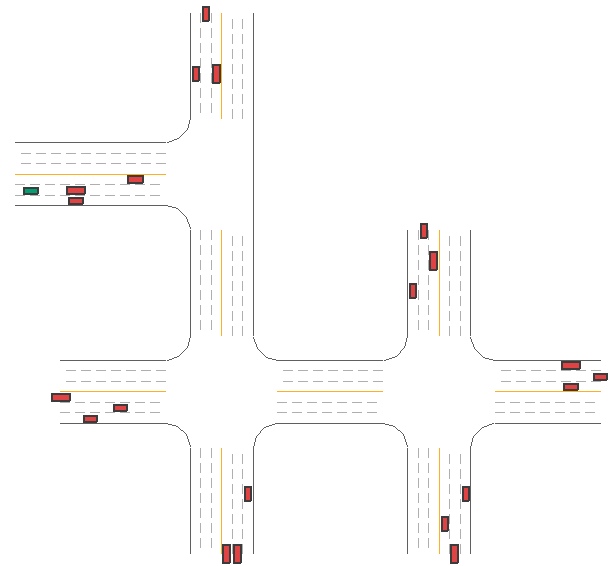
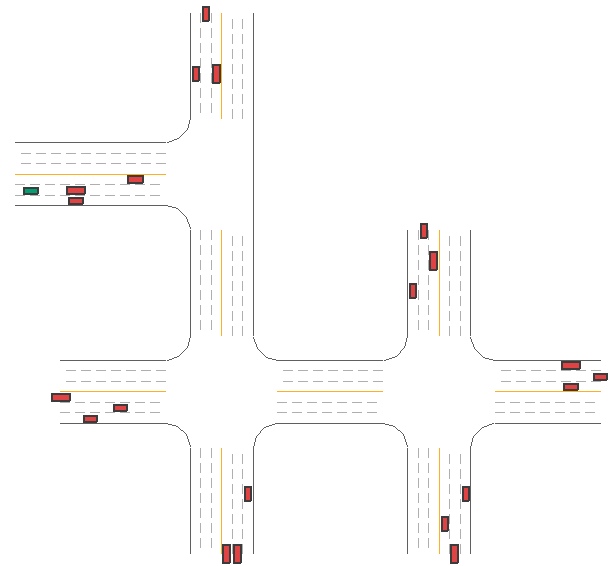

In [11]:
mediapy.set_show_save_dir("data")

mediapy.show_videos(
    [frames_a, frames_b[::2]],
    titles=["bad_10FPS", "bad_20FPS"],
    fps=10,
    codec="gif",
)
# mediapy.show_videos([frames_a, frames_b], titles=["First run", "Second run"], fps=10)

In [12]:
env = MultiFidelityEnv(10)

[INFO] Environment: MultiFidelityEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None


In [13]:
_ = env.reset()
action = expert(env.agent, deterministic=True)
obs, reward, terminated, truncated, info = env.step(action)

[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Fidelity parameters in MultiFidelityTrafficManager: dr=1, dt=0.1, fps=10.0, skip=1.0
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Entering before step, skip_counter=0, skip_limit=1.0
[INFO] Setting BV policy


In [14]:
# env.current_map.get_meta_data()
# env.engine.traffic_manager._traffic_vehicles